<a href="https://colab.research.google.com/github/katjasit0815/Data-Science-academic-projects/blob/main/02_Naive_bayes_for_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --user -U nltk

In [ ]:
from google.colab import files
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score
from sklearn.metrics import classification_report
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression


import nltk, re, string
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.base import SamplerMixin
from collections import Counter

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
files.upload()

!pip install --upgrade --quiet kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d arkhoshghalb/twitter-sentiment-analysis-hatred-speech
!unzip -q twitter-sentiment-analysis-hatred-speech

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech
License(s): unknown
twitter-sentiment-analysis-hatred-speech.zip: Skipping, found more recently modified local copy (use --force to force download)
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## EDA

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
pd.concat([train, test], axis=0, ignore_index=True).info()
print()
print('Форма train и test',train.shape, test.shape)
print("Дубликатов строк в train и test:", train.duplicated().sum(), 'и', test.duplicated().sum())
train.groupby("label").count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49159 entries, 0 to 49158
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      49159 non-null  int64  
 1   label   31962 non-null  float64
 2   tweet   49159 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ MB

Форма train и test (31962, 3) (17197, 2)
Дубликатов строк в train и test: 0 и 0


,id,tweet
label,,
0,29720,29720
1,2242,2242


Мы видим значительный дисбаланс классов.

In [ ]:
y = train['label']
X = train['tweet']

In [ ]:
def train_test_nb(X, y,
                  test_size=0.2,
                  random_state=0,
                  ngram_range=(1, 1),
                  vectorizer=None,
                  model=None,
                  sampler: SamplerMixin = None):
    """
    1) Делит X, y на train/test,
    2) Векторизует тексты TF–IDF по умолчанию,
    3) Обучает MultinomialNB по умолчанию,
    4) Возвращает (y_train, y_test, y_pred, vectorizer, model,sampler)
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    vectorizer = vectorizer or TfidfVectorizer()
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec  = vectorizer.transform(X_test)

    if sampler is not None:
        try:
            X_res, y_res = sampler.fit_resample(X_train_vec, y_train)
        except (ValueError, TypeError):
            X_res, y_res = sampler.fit_resample(X_train_vec.toarray(), y_train)
    else:
        X_res, y_res = X_train_vec, y_train

    model = model or MultinomialNB()
    model.fit(X_res, y_res)

    y_pred = model.predict(X_test_vec)
    print(classification_report(y_test, y_pred))

    return y_train, y_test, y_pred, vectorizer, model, sampler

In [ ]:
y_train, y_test, y_pred, vectorizer, model, sampler = train_test_nb(X, y)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5985
           1       1.00      0.10      0.18       408

    accuracy                           0.94      6393
   macro avg       0.97      0.55      0.57      6393
weighted avg       0.95      0.94      0.92      6393



Можем сделать вывод по низкому recall, что модель плохое различает сексистские и расистские высказывания, вероятно из-за дисбаланса классов. Сделаем предобработку текста и сравним метрики с добавлением лематизации.

In [ ]:
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
lemmatizer  = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    """
    Преобразует тег части речи из pos_tag в формат, понятный WordNetLemmatizer.
    Если не распознаётся, возвращает NOUN по умолчанию.
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
def preprocess_and_lemmas(text):
    text = str(text).lower()        #приводим к нижнему регистру
    words = word_tokenize(text)     #токенизируем
    filtered_words = [              #убираем стоп слова и знаки пунктуации
        w for w in words
        if w not in stop_words and w not in punctuation]
    pos_tags = nltk.pos_tag(filtered_words)

    lemmas = [
        lemmatizer.lemmatize(w, get_wordnet_pos(tag))
        for w, tag in pos_tags
    ]

    return " ".join(lemmas)

In [ ]:
preprocessed_X_lemmas = X.apply(preprocess_and_lemmas)
y_train, y_test, y_pred, vectorizer, model, sampler = train_test_nb(preprocessed_X_lemmas, y)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5985
           1       1.00      0.12      0.22       408

    accuracy                           0.94      6393
   macro avg       0.97      0.56      0.59      6393
weighted avg       0.95      0.94      0.92      6393



In [ ]:
def preprocess_text(text):
    text = str(text).lower()
    words = word_tokenize(text)
    filtered_words = [
    w for w in words
    if w not in stop_words and w not in punctuation]
    return " ".join(filtered_words)

In [ ]:
preprocessed_X = X.apply(preprocess_text)
y_train, y_test, y_pred, vectorizer, model, sampler = train_test_nb(preprocessed_X, y)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5985
           1       1.00      0.13      0.23       408

    accuracy                           0.94      6393
   macro avg       0.97      0.56      0.60      6393
weighted avg       0.95      0.94      0.92      6393



Таким образом, recall без обработки текста составляет 0.10, с обработкой текста и лемматизацией составляет 0.12, с обработкой и без лематизации - 0.13 (этот вариант и будем использовать). Далее используем биграммы, а также будем менять модель и векторайзер.

In [ ]:
y_train, y_test, y_pred, vectorizer, model,sampler = train_test_nb(preprocessed_X, y,ngram_range=(1,3))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5985
           1       1.00      0.13      0.23       408

    accuracy                           0.94      6393
   macro avg       0.97      0.56      0.60      6393
weighted avg       0.95      0.94      0.92      6393



Использование биграмм не изменило метрики.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    preprocessed_X, y, test_size=0.2, random_state=0)
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB())
])
res = []
param_grid = [
    {
      'vect': [CountVectorizer(), TfidfVectorizer()],
      'clf':  [MultinomialNB()],
      'clf__alpha': [0.1, 0.5, 1.0, 2.0]
    },
    {
      'vect': [CountVectorizer(), TfidfVectorizer()],
      'clf':  [ComplementNB()],
      'clf__alpha': [0.1, 0.5, 1.0],
      'clf__norm':  [True, False]
    },
]

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

y_pred = grid.predict(X_test)

print("recall:", recall_score(y_test, y_pred))
print("precision:", precision_score(y_test, y_pred))
print("f1-score:", f1_score(y_test, y_pred))


Best params: {'clf': MultinomialNB(), 'clf__alpha': 0.1, 'vect': CountVectorizer()}
Best CV score: 0.7048437499987017
recall: 0.7254901960784313
precision: 0.6836027713625866
f1-score: 0.703923900118906


In [ ]:
def plot_cm(y_true, y_pred, ax=None,title=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['NOT Racist', 'Racist'],
                yticklabels=['NOT Racist', 'Racist'])
    ax.set_xlabel('Предсказано')
    ax.set_ylabel('Фактически')
    if title:
        ax.set_title(title)
    return ax

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5985
           1       0.68      0.73      0.70       408

    accuracy                           0.96      6393
   macro avg       0.83      0.85      0.84      6393
weighted avg       0.96      0.96      0.96      6393



<Axes: title={'center': 'CountVectorizer() + MultinomialNB(alpha=0.1)'}, xlabel='Предсказано', ylabel='Фактически'>

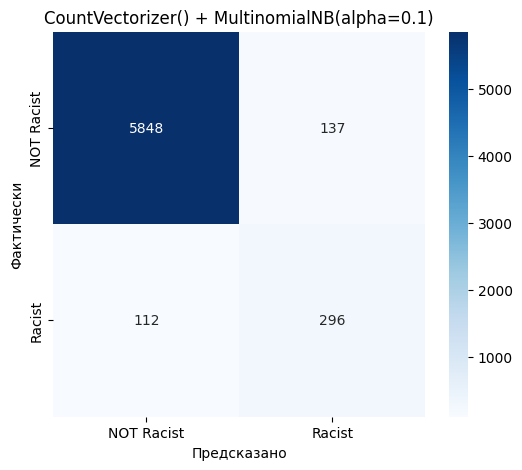

In [ ]:
y_train, y_test, y_pred, vectorizer, model, sampler = train_test_nb(preprocessed_X,
                                                                    y,
                                                                    vectorizer=CountVectorizer(),
                                                                    model = MultinomialNB(alpha=0.1))
title = f"{vectorizer} + {model}"
plot_cm(y_test, y_pred, title=title)

Таким образом, модель MultinomialNB + CountVectorizer наиболее оптимально определяет расиситские и сексистские высказывания среди других моделей наивного Байеса и векторизаторов с F1-score = 0.7

##Undersampling/oversamling

In [ ]:
y_train, y_test, y_pred, vectorizer, model, sampler = train_test_nb(preprocessed_X,
                                                                    y,
                                                                    vectorizer=CountVectorizer(),
                                                                    model = MultinomialNB(alpha=0.1),
                                                                    sampler=RandomUnderSampler(random_state=0))

              precision    recall  f1-score   support

           0       0.99      0.85      0.91      5985
           1       0.28      0.89      0.43       408

    accuracy                           0.85      6393
   macro avg       0.64      0.87      0.67      6393
weighted avg       0.95      0.85      0.88      6393



In [ ]:
print("Удалено всего:", len(y_train)- len(y_pred))

Удалено всего: 19176


recall: 0.8921568627450981
accuracy: 0.8492100735179102
f1_score: 0.4302600472813239


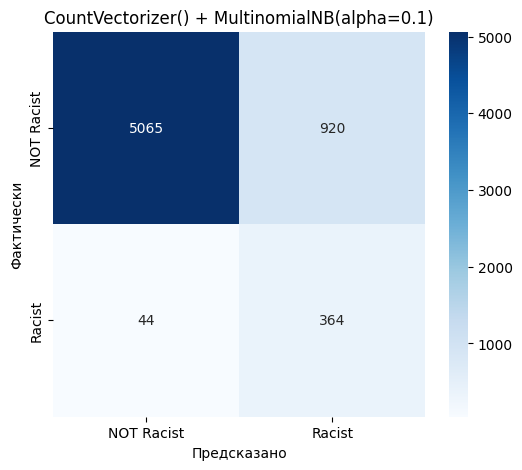

In [ ]:
title = f"{vectorizer} + {model}"
plot_cm(y_test, y_pred,title=title)

print('recall:',recall_score(y_test,y_pred))
print('accuracy:',accuracy_score(y_test,y_pred))
print('f1_score:',f1_score(y_test,y_pred))

С использованием RandomUnderSampler модель слишком строго оценивает высказывания и слишком много твитов отнесла к негативным, f1-score значительно упал.

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5985
           1       0.68      0.73      0.70       408

    accuracy                           0.96      6393
   macro avg       0.83      0.85      0.84      6393
weighted avg       0.96      0.96      0.96      6393



<Axes: title={'center': 'CountVectorizer() + MultinomialNB(alpha=0.1)'}, xlabel='Предсказано', ylabel='Фактически'>

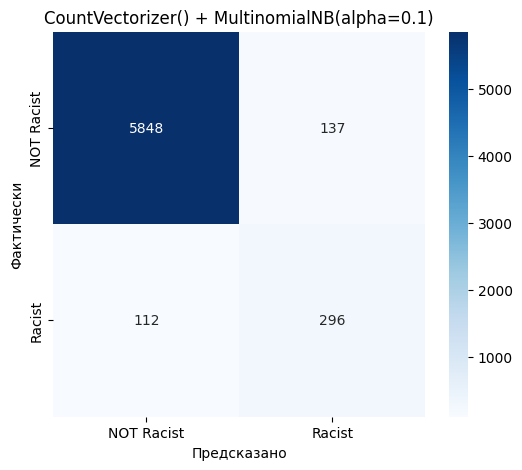

In [ ]:
y_train, y_test, y_pred, vectorizer, model, sampler = train_test_nb(preprocessed_X,
                                                                    y,
                                                                    vectorizer=CountVectorizer(),
                                                                    model = MultinomialNB(alpha=0.1),
                                                                    sampler=TomekLinks())
title = f"{vectorizer} + {model}"
plot_cm(y_test, y_pred, title=title)

In [ ]:
print('recall:',recall_score(y_test,y_pred))
print('accuracy:',accuracy_score(y_test,y_pred))
print('f1_score:',f1_score(y_test,y_pred))

recall: 0.7254901960784313
accuracy: 0.9610511496949788
f1_score: 0.703923900118906


Поиск связей Томека не улучшил базовую модель без sampler.

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      5985
           1       0.51      0.75      0.60       408

    accuracy                           0.94      6393
   macro avg       0.74      0.85      0.78      6393
weighted avg       0.95      0.94      0.94      6393



<Axes: title={'center': 'CountVectorizer() + MultinomialNB(alpha=0.1)'}, xlabel='Предсказано', ylabel='Фактически'>

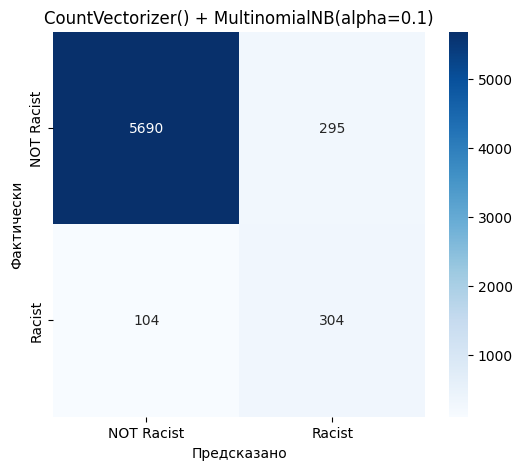

In [ ]:
y_train, y_test, y_pred, vectorizer, model, sampler = train_test_nb(preprocessed_X,
                                                                    y,
                                                                    vectorizer=CountVectorizer(),
                                                                    model = MultinomialNB(alpha=0.1),
                                                                    sampler=RandomOverSampler(random_state=0))
title = f"{vectorizer} + {model}"
plot_cm(y_test, y_pred,title=title)

In [ ]:
print('recall:',recall_score(y_test,y_pred))
print('accuracy:',accuracy_score(y_test,y_pred))
print('f1_score:',f1_score(y_test,y_pred))

recall: 0.7450980392156863
accuracy: 0.9375879868606288
f1_score: 0.6037735849056604


RandomOverSampler показал более оптимальный результат на метриках recall и f1-score по сравнению с RandomUnderSampler.
Тем не менее, f1-score после применения RandomOverSampler остается меньше, чем до применения сэмплера.

## SMOTE & ADASYN

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      5985
           1       0.58      0.67      0.63       408

    accuracy                           0.95      6393
   macro avg       0.78      0.82      0.80      6393
weighted avg       0.95      0.95      0.95      6393



<Axes: title={'center': 'CountVectorizer() + MultinomialNB(alpha=0.1)'}, xlabel='Предсказано', ylabel='Фактически'>

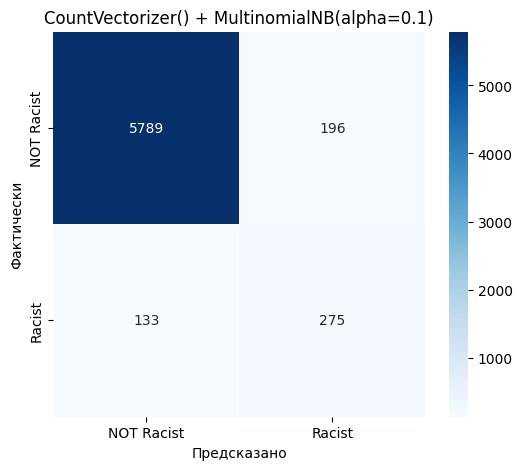

In [ ]:
y_train, y_test, y_pred, vectorizer, model, sampler = train_test_nb(preprocessed_X,
                                                                    y,
                                                                    vectorizer=CountVectorizer(),
                                                                    model = MultinomialNB(alpha=0.1),
                                                                    sampler=SMOTE(random_state=0))
title = f"{vectorizer} + {model}"
plot_cm(y_test, y_pred,title=title)

In [ ]:
print('recall:',recall_score(y_test,y_pred))
print('accuracy:',accuracy_score(y_test,y_pred))
print('f1_score:',f1_score(y_test,y_pred))

recall: 0.6740196078431373
accuracy: 0.9485374628499922
f1_score: 0.6257110352673493


              precision    recall  f1-score   support

           0       0.98      0.95      0.97      5985
           1       0.50      0.74      0.60       408

    accuracy                           0.94      6393
   macro avg       0.74      0.84      0.78      6393
weighted avg       0.95      0.94      0.94      6393



<Axes: title={'center': 'CountVectorizer() + MultinomialNB(alpha=0.1)'}, xlabel='Предсказано', ylabel='Фактически'>

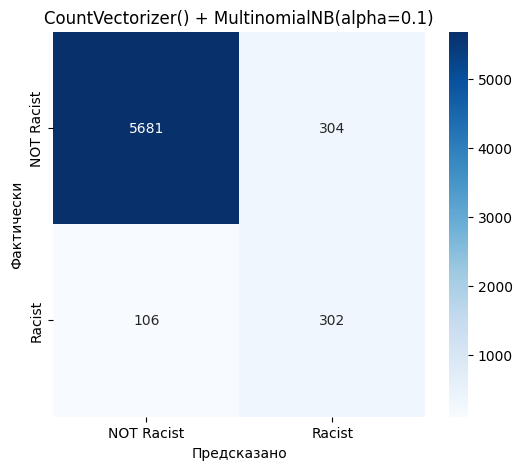

In [ ]:
y_train, y_test, y_pred, vectorizer, model, sampler = train_test_nb(preprocessed_X,
                                                                    y,
                                                                    vectorizer=CountVectorizer(),
                                                                    model = MultinomialNB(alpha=0.1),
                                                                    sampler=ADASYN(random_state=0))
title = f"{vectorizer} + {model}"
plot_cm(y_test, y_pred,title=title)

In [ ]:
print('recall:',recall_score(y_test,y_pred))
print('accuracy:',accuracy_score(y_test,y_pred))
print('f1_score:',f1_score(y_test,y_pred))

recall: 0.7401960784313726
accuracy: 0.9358673549194432
f1_score: 0.5956607495069034


## Обучение

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    preprocessed_X, y, test_size=0.2, random_state=0)
pipeline = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,3), max_df=0.8, min_df=5, max_features=20_000)),
    ('clf',   LogisticRegression(
                  penalty='l2',
                  C=1.0,
                  solver='liblinear',
                  max_iter=2000,
                  random_state=42))
])

param_grid = {
    'clf__penalty': ['l1','l2'],
    'clf__C':       [1, 3, 5, 7]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
print("Лучший F1 макро:", grid.best_score_)

Лучшие параметры: {'clf__C': 5, 'clf__penalty': 'l1'}
Лучший F1 макро: 0.6646624552635522


In [ ]:
poly = PolynomialFeatures(
    degree=2,
    interaction_only=True,
    include_bias=False,
)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=5, max_df=0.8, max_features=2000)),
    ('poly', poly),
    ('svd',   TruncatedSVD(n_components=100, random_state=42)),
    ('clf',   LogisticRegression(max_iter=1000, penalty='l1', C=5, solver='liblinear', random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Train f1:",
      f1_score(y_train, pipeline.predict(X_train)))
print("Test  f1:",
      f1_score(y_test,  pipeline.predict(X_test)))

Train f1: 0.3755674783326455
Test  f1: 0.3559633027522936


Таким образом, логистическая регрессия с l1 регуляризацией справляется лучше без понижения размерности и добавления полиномиальных признаков.